In [1]:
!pip install d2l

In [21]:
%matplotlib inline
import math
import time
import numpy as np
from torch import nn
from d2l import torch as d2l

### Vctorization for Speed


In [3]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [6]:
c = torch.zeros(n)
t = time.time()

for i in range(n):
  c[i] = a[i]+ b[i]
f'{time.time() - t: .5f}sec'

' 0.16699sec'

In [7]:
t = time.time()
d = a + b
f'{time.time() - t: .5f}sec'

' 0.00040sec'

In [8]:
# normal distribution of the code
def normal(x,mu,sigma):
  p = 1/math.sqrt(2*math.pi*sigma**2)
  return p*np.exp(-0.5*(x-mu)**2/sigma**2)

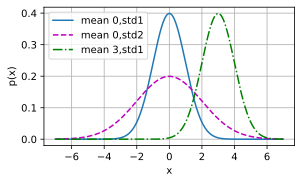

In [9]:
# plotting the graph

x = np.arange(-7,7,0.01)
params = [(0,1),(0,2),(3,1)]
d2l.plot(x,[normal(x,mu,sigma) for mu, sigma in params],xlabel='x',
         ylabel='p(x)', figsize=(4.5,2.5),
         legend=[f'mean {mu},std{sigma}' for mu , sigma in params])

### Object Oriented Design For Implementation

In [11]:
import time
import numpy as np
import torch
from d2l import torch as d2l

In [12]:
def add_to_class(Class):
  def wrapper(obj):
    setattr(Class,obj.__name__,obj)
  return wrapper

In [13]:
class A:
  def __init__(self):
    self.b = 1

a = A()

In [14]:
@add_to_class(A)
def do(self):
  print('Class attribute "b" is ',self.b)

a.do()

Class attribute "b" is  1


In [15]:
class HyperParameters:
  def save_hyperparameters(self,ignore=[]):
    raise NotImplemented

In [17]:
class B(d2l.HyperParameters):
  def __init__(self,a,b,c):
    self.save_hyperparameters(ignore=['c'])
    print('self.a =',self.a, 'self.b = ',self.b)
    print('There is no self.c = ', not hasattr(self,'c'))
b = B(a = 1, b = 2,c =3)

self.a = 1 self.b =  2
There is no self.c =  True


In [18]:
class ProgressBoard(d2l.HyperParameters):
  def __init__(self, xlabel=None, ylabel=None,xlim=None,
               ylim = None, xscale='linear',yscale='linear',
               ls=['-','--','-.',':'],colors=['C0','C1','C2','C3'],
               fig=None,axes=None,figsize=(3.5,2.5),display=True):
    self.save_hyperparameters()
  def draw(self,x,y,label,every_n=1):
    raise NotImplemented

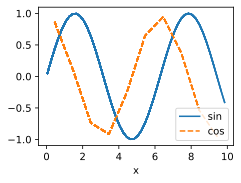

In [19]:
board = d2l.ProgressBoard('x')
for x in np.arange(0,10,0.1):
  board.draw(x,np.sin(x),'sin',every_n=2)
  board.draw(x,np.cos(x),'cos',every_n=10)

### Models
We have all the required models here:
- ___init___ : stores the learnable parameters
- training_step : accepts data batch to return loss
- configure_optimzers : returns optimization mthod
- validation_step : reports th eval measures

In [23]:
class Module(nn.Module, d2l.HyperParameters):
  def __init__(self,plot_train_per_epoch=2, plot_valid_per_epoch=1):
    super().__init__()
    self.sav_hypreparameters()
    self.board = ProgressBoard()

  def loss(self,y_hat,y):
    raise NotImplementedError

  def forward(self,X):
    assert hasattr(self,'net'), 'NN is defined'
    return self.net(X)

  def plot(self,key,value,train):
    assert hasattr(self,'trainer'), 'Trainer is not defined'
    self.board.xlabel = 'epoch'
    if train:
      x = self.trainer.train_batch_idx / \
        self.trainer.num_train_batches
      n = self.trainer.num_train_batches/ \
        self.plot_traineer_per_epoch
    else:
      x = self.trainer.epoch + 1
      n = self.trainre.num_val_batches / \
        self.plot_valid_per_epoch
      self.board.draw(x,value.to(d2l.cpu()).detach().numpy(),
                      ('train_' if train else 'val_') + key ,
                      every_n= int(n))

      def training_step(self,batch):
        l = self.loss(self(*batch[:-1]),batch[-1])
        self.plot('loss',l,train=True)
        return l

      def validation_step(self,batch):
        l = self.loss(self(*batch[:-1]),batch[-1])
        self.plot('loss',l,train=False)
        return l

      def configure_optimizers(self):
        return


###  Data

In [25]:
class DataModule(d2l.HyperParameters):

  def __init__(self, root='../data',num_workers=4):
    self.save_hyperparameters()
  def get_dataloader(self,train):
    raise NotImplementedError
  def train_dataloader(self):
    return self.get_dataloader(train=True)
  def val_dataloader(self):
    return self.get_dataloader(train=False)

### Training

In [28]:
class Trainer(d2l.HyperParameters):
  def __init__(self,max_epochs,num_gpus=0,gradient_clip_val=0):
    self.save_hyperparameters()
    assert num_gpus==0,'NO GPU SUPPORT'

  def prepare_data(self,data):
    self.train_dataloader = data.train_dataloader()
    self.val_dataloader = data.val_dataloader()
    self.num_train_batches = len(self.train_dataloader)
    self.num_val_batches = (len(self.val_dataloader)
                          if self.val_dataloader is not None else 0)

  def prepare_model(self,model):
    model.trainer = self
    model.board.xlim = [0,self.max_epochs]
    self.model = model

  def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

  def fit_epoch(self):
        raise NotImplementedError